In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
test_data  = pd.read_table('ratings_test.txt')
train_data  = pd.read_table('ratings_train.txt')

In [14]:
train_data[:3]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [15]:
test_data[:3]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0


In [16]:
# 데이터 중복 확인 -> unique
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [17]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [21]:
print(len(train_data))
print(train_data['label'].value_counts())

146183
0    73342
1    72841
Name: label, dtype: int64


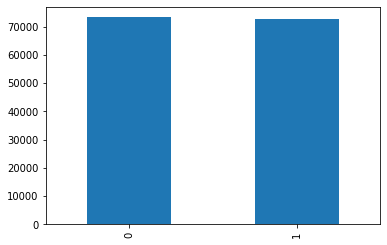

In [19]:
train_data['label'].value_counts().plot(kind='bar')

In [28]:
# train_data['label'].isnull().sum()
print(train_data.isnull().sum())
train_data.loc[train_data.document.isnull()]

id          0
document    1
label       0
dtype: int64


,id,document,label
25857,2172111,NaN,1


In [30]:
train_data = train_data.dropna(how='any')
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [ ]:
# 공백, 특수문자 제거 
#공백 문자 쪼개기 . re.sub(r'[^a-zA-Z]', '', text) 영어만 남길때
# ㄱ~ㅎ : U3131 ~ U314E
# ㅏ ~ ㅣ : ..
# 가 ~ 힣 : UAC00 ~ ... 

In [31]:
train_data['document']=train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z]", "")

C:\Users\LGPC\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
train_data[:5]

,id,document,label
0,9976970,아더빙진짜짜증나네요목소리,0
1,3819312,흠포스터보고초딩영화줄오버연기조차가볍지않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소이야기구먼솔직히재미는없다평점조정,0
4,6483659,사이몬페그의익살스런연기가돋보였던영화스파이더맨에서늙어보이기만했던커스틴던스트가너무나도이...,1


In [34]:
train_data['document'].replace('',np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    179
label         0
dtype: int64


C:\Users\LGPC\Anaconda3\envs\keras\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [35]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
1840,7095375,NaN,1
2327,9317820,NaN,1


In [36]:
train_data = train_data.dropna(how='any')


In [37]:
print(len(train_data))

146003


In [39]:
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document']=test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z]", "")
test_data['document'].replace('',np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print("테스트 데이터 : ", len(test_data))


테스트 데이터 :  49072


## Tokenizer

In [41]:
#stopwrods -> 한국어의 조사 은, 는, 이, 가, 을, 를, 잘, 도 ......
#꼭 조사 뿐만 아니라 필요 없다고 생각한 것들 넣기. 

In [43]:
stopwords = ['의','가','이','는','은','들','잘','좀','과','와','도','을','를','으로','한','하다','에']

In [45]:
from konlpy.tag import Okt
okt = Okt()

In [48]:
okt.morphs("2000년 이후 최고의 서스팬스 영화...라고 했지만, 이걸 왜 봤을까?",stem=True)

['2000년',
 '이후',
 '최고',
 '의',
 '서스팬스',
 '영화',
 '...',
 '라고',
 '하다',
 ',',
 '이',
 '걸',
 '왜',
 '보다',
 '?']

In [49]:
# 불용어 제거, 형태소 토큰화 작업
X_train = []
for sentences in train_data['document']:
    temp_x = []
    temp_x = okt.morphs(sentences, stem=True) #tokenizing
    temp_x = [word for word in temp_x if not word in stopwords] # stop word 
    X_train.append(temp_x)
print(X_train[:5])

[['아더', '빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'], ['사이', '몬페', '그', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '에서', '늙다', '보이다', '크다', '스틴던스트', '너무나도', '이쁘다', '보이다']]


In [50]:
# 불용어 제거, 형태소 토큰화 작업
X_test = []
for sentences in test_data['document']:
    temp_x = []
    temp_x = okt.morphs(sentences, stem=True) #tokenizing
    temp_x = [word for word in temp_x if not word in stopwords] # stop word 
    X_test.append(temp_x)
print(X_test[:5])

[['굳다', 'ㅋ'], ['GDNTOPCLASSINTHECLUB'], ['뭐', '야', '평점', '나쁘다', '않다', '만점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임돈', '주다', '보기', '에는'], ['D', '만', '아니다', '별', '다섯', '개', '주다', '왜', 'D', '로나', '서', '제', '심기', '불편하다']]


In [51]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '없다': 3, '이다': 4, '좋다': 5, '다': 6, '너무': 7, '하': 8, '정말': 9, '재밌다': 10, '적': 11, '되다': 12, '같다': 13, '있다': 14, '만': 15, '진짜': 16, '않다': 17, '로': 18, '아니다': 19, '에서': 20, '내': 21, '평점': 22, '그': 23, '최고': 24, '인': 25, '나': 26, '연기': 27, '생각': 28, '스토리': 29, '점': 30, '게': 31, '이영화': 32, '드라마': 33, '감동': 34, '사람': 35, '만들다': 36, '고': 37, '요': 38, '나오다': 39, '아깝다': 40, '지': 41, '이런': 42, 'ㅋㅋ': 43, '보고': 44, '배우': 45, '재미있다': 46, '왜': 47, '감독': 48, '때': 49, '네': 50, '들다': 51, '하고': 52, '그냥': 53, '아': 54, '재미없다': 55, '시간': 56, '가다': 57, '까지': 58, '못': 59, '중': 60, '지루하다': 61, '것': 62, '뭐': 63, '재미': 64, '쓰레기': 65, '말': 66, '면': 67, '주다': 68, '본': 69, '모르다': 70, '작품': 71, '알다': 72, '더': 73, '오다': 74, '거': 75, '자다': 76, '그렇다': 77, '사랑': 78, '마지막': 79, '저': 80, '대': 81, '정도': 82, '화': 83, 'ㅠㅠ': 84, '이나': 85, '많다': 86, '완전': 87, 'ㅋㅋㅋ': 88, '처음': 89, '라': 90, 'ㅋ': 91, '안되다': 92, '개': 93, '액션': 94, '이렇게': 95, '주인공': 96, '니': 97, '최악': 98, '내용': 99, '느낌': 100, '이렇다': 101, 'ㅡㅡ': 1

In [53]:
threshold = 3 # 빈도수 (3회 미만 무시 )
total_cnt = len(tokenizer.word_index) #단어수
rare_cnt = 0 # 빈도수가 threshold 보다 작은 단어수
total_freq = 0 # 훈련 데이터 전체 단어 빈도수 총 합
rate_freq = 0 # 빈도수가 threshold 보다 작은 단어들의 총 합

# 단어와 빈도수의 pair를 key, value로 철
for key, value in tokenizer.word_index.items():
    total_freq = total_freq + value
    
    #단어 빈도수가 threshold보다 작은 값 처리
    
    if (value < threshold):
        rare_cnt += 1
        rate_freq += value

In [54]:
print('총 단어 수(Vocabulary):', total_cnt)
print('빈도수 낮은 수:', rare_cnt)
print('단어 집합에서 빈도수가 낮은 단어 비율:', ((rare_cnt/total_cnt)*100))
print('전체 출현 단어에서 빈도수가 낮은 단어 비율: ', ((rate_freq/total_freq)*100))

# 전체 단어 수 중 빈도수가 3이하인 단어 제거, 
vocab_size = total_cnt - rare_cnt +1
print('단어 집합의 크기:', vocab_size)

총 단어 수(Vocabulary): 48395
빈도수 낮은 수: 2
단어 집합에서 빈도수가 낮은 단어 비율: 0.004132658332472363
전체 출현 단어에서 빈도수가 낮은 단어 비율:  2.561776799201812e-07
단어 집합의 크기: 48394


In [55]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3]) #[[150, 12, 434, 5, 454, ... ]]

[[9949, 11535, 16, 249, 668], [1073, 473, 44, 612, 1, 407, 1517, 27, 1089, 687, 17], [213, 1731, 27363, 576, 3875, 2, 225, 6]]


In [56]:
Y_train = np.array(train_data['label'])
Y_test = np.array(test_data['label'])

In [57]:
#빈 샘플 데이터 제거

In [59]:
#패딩 처리
#최대 리뷰 길이, 평균 리뷰 길이 구하기 

max_review_length = max(len(x) for x in X_train)
print("최대 리뷰 길이 : ", max_review_length)

# ave, mean... 
mean_review_length = sum(map(len, X_train)) / len(X_train)
print("평균 리뷰 길이 : ", mean_review_length)

plt.hist((len(s) for s in X_trian), bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

최대 리뷰 길이 :  68
평균 리뷰 길이 :  10.833811634007521


NameError: name 'X_trian' is not defined

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

## LSTM을 이용한 리뷰 모델 생성


In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #학습률에 변ㅇ화가 없으면 멈춘다. 

In [ ]:
T = X_train.shape[1] #30
i - INput(shape=(T,))
x = Embedding(V,D)(i) # V? D?
x = LSTM(128)(x)
x = Dense(1,activation='sigmoid')(x)
model = Model(i,x)
model.summary()

In [ ]:
eStop = EarlyStoping(monitor = 'val_loss', mode='min', verbose=1, patience=5)
mCheck = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs=10, validation_split=0.2, batch_size=60, callbackds=[eStop, mCheck])

In [ ]:
println("테스트 정확도:",model.evaluate(X_test, Y_test)[1])
#테스트 정확도 : 0.8 xxx
